# Load libraries and Data

In [1]:
from pyhive import presto

def get_presto_conn():
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086)

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()
conn = get_presto_conn() 

import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)

from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

# dWeb Checkout Migration test

In [2]:
# latest ramp period
start_date = '2022-04-29'
end_date = '2022-05-04'
test_name = 'mp_checkout_dweb_v2'
control = 'control'
treatment = 'treatment'
device_cat = "('Personal computer')" 
# device_cat = "('Tablet','Smartphone')"
tmp_user_table1 = 'wandajuan.visitor_base_' + test_name
tmp_user_table2 = 'wandajuan.mp_metrics_' + test_name
tmp_user_table4 = 'wandajuan.xo_metrics_' + test_name
tmp_user_table5 = 'wandajuan.xo_funnel_action_' + test_name
tmp_user_table3 = 'wandajuan.' + test_name

## User Base

In [8]:
# Test user base:

print('run query below in presto:')

q = """
CREATE TABLE {tmp_user_table1} AS
with first_trigger as
    (
    SELECT 
       visitor_id
       , min(test_variant) as test_value_min
       , max(test_variant) as test_value_max
       , min(dt) as ft_dt
    FROM l2.test_selection
    WHERE test_name = '{test_name}'
    and dt BETWEEN '{start_date}' AND '{end_date}'
    and visitor_id in (
                        select distinct visitor_id
                            from l2.session_analytics core 
                        WHERE core.dt BETWEEN '{start_date}' AND '{end_date}'
                          and CAST(country as varchar) in ('US') 
                          and CAST(site_id as varchar) in ('101') 
                          AND device_cat != '' 
                          AND (test_set like '%{test_name}=%') 
                          and device_cat in {device_cat}
                          and session_id not in (
                                            select session_id 
                                            from l2.session_summary 
                                            where user_agent like '%test_automation%' 
                                            and dt>= '{start_date}') 
                      )
    group by visitor_id
    having min(test_variant) = max(test_variant)
    )
    SELECT visitor_id,test_value_min as test_variant, ft_dt as dt
    FROM first_trigger
""".format(tmp_user_table1=tmp_user_table1,
            test_name=test_name,
            start_date=start_date,
            end_date=end_date,
              device_cat = device_cat)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,1902


In [3]:
pd.read_sql("""Select test_variant,  count(visitor_id) from {tmp_user_table1} group by 1 order by 1""".format(tmp_user_table1=tmp_user_table1),conn)

,test_variant,_col1
0,control,978
1,treatment,922
2,treatment_qa,2


with or without dedup, total # visitors in manual pull is less than abdash, which is 1041+987+2 

In [37]:
test_users = pd.read_sql('select * from {tmp_user_table1}'.format(tmp_user_table1=tmp_user_table1), conn)
test_users

,visitor_id,test_variant,dt
0,eae7d9a8-a895-4a01-9c17-36c51f5a087a,control,2022-04-29
1,5d7b5269-f9fb-4dce-8a75-aa285ea63549,control,2022-04-30
2,601cac81-2008-4af1-9d59-9a9e58a48c6e,treatment,2022-05-04
3,3b3b624b-71d8-4130-a29e-7bbd418de30a,control,2022-05-03
4,f6c8fe1d-e38f-4536-bdb3-f1987e7f9358,control,2022-05-02
...,...,...,...
1897,08cc5dab-eacc-416f-8bc2-d5b37cf1d880,control,2022-04-29
1898,e6db31c1-9e7c-47f6-b351-a57ee935798d,treatment,2022-04-29
1899,3baf2914-26e3-45ad-86c9-4e81e0b0521c,treatment,2022-05-02
1900,7c510f87-dfc0-4d06-84bd-46bf4dce02d0,treatment,2022-05-01


## MP table

In [80]:
# MP Metrics: since there are not that many rows - 2K+ -> pull the entire pos
pd.read_sql('drop table {tmp_user_table2}'.format(tmp_user_table2=tmp_user_table2), conn)


print('run query below in presto:')

q = """
CREATE TABLE {tmp_user_table2} AS

select 
		t0.*,
		t2.order_date, 
		t2.order_id,
		t2.created,
		t2.status,
		t2.item_id, 
		t2.house_id,
		t2.item_gmv,
		t2.init_item_commission,
		t2.gmv_net_of_returns,
		t2.net_commission,
		t2.placed_order_item_coupon_amount,
		t2.is_trade_program,
		t2.session_id,
		t2.medium,
		t2.l1_category,
		t2.browser,
		t2.os,
		t2.device_cat,
		t2.channel,
		t2.new_visitor,
		t2.landing_page_class,
		
		( case when checkout_type = 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as new_orders,
		( case when checkout_type != 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as old_orders,
		( case when billing_info like '%paymentMethodType":0%' then t2.order_id end) as cc_orders,
		( case when billing_info like '%paymentMethodType":1%' then t2.order_id end) as apple_pay_orders,
		( case when billing_info like '%paymentMethodType":4%' then t2.order_id end) as afterpay_orders,
		( case when billing_info like '%paymentMethodType":3%' then t2.order_id end) as paypal_orders,
		( case when billing_info like '%paymentMethodType":0%' then t2.item_gmv end) as cc_gmv,
		( case when billing_info like '%paymentMethodType":1%' then t2.item_gmv end) as apple_pay_gmv,
		( case when billing_info like '%paymentMethodType":4%' then t2.item_gmv end) as afterpay_gmv,
		( case when billing_info like '%paymentMethodType":3%' then t2.item_gmv end) as paypal_gmv
from {tmp_user_table1} t0 
join  mp_test.order_item_details t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.order_date >= t0.dt 
  and order_date between '{start_date}' and '{end_date}' 
join logs.marketplace_valid_orders_detailed_daily t4
    on t2.order_id = t4.order_id
where t2.status in (0,1,2,3,4,5,20,99) 
  and t2.is_impersonated = 0 
  -- and is_trade_program = 0
-- GROUP BY 1 ,2
""".format(tmp_user_table1=tmp_user_table1,
           tmp_user_table2 = tmp_user_table2,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,2217


In [197]:
# mp = pd.read_sql("select * from {tmp_user_table2}".format(tmp_user_table2=tmp_user_table2), conn)
# mp

## XO Table

In [ ]:
# Checkout Metrics:

print('run query below in presto:')

q = """
CREATE TABLE {tmp_user_table4} AS

select 
	t0.test_variant,
	t0.dt as trigger_dt,
	t2.*
from {tmp_user_table1} t0 
join l2.session_analytics t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '{start_date}' and '{end_date}' 
-- GROUP BY 1 ,2
""".format(tmp_user_table1=tmp_user_table1,
           tmp_user_table4 = tmp_user_table4,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

In [198]:
# xo = pd.read_sql("select * from {tmp_user_table4}".format(tmp_user_table4 = tmp_user_table4), conn)
# xo

## XO funnel actions

In [34]:

# Checkout funnel with sign in status at the time:

print('run query below in presto:')

q = """
CREATE TABLE {tmp_user_table5} AS

select 
	t0.test_variant,
	t0.dt as trigger_dt,
	t2.*,
	coalesce(json_extract_scalar(action_metadata, '$.app'), json_extract_scalar(action_metadata, '$.originatingPageData["app"]'))  app,
	coalesce(json_extract_scalar(action_metadata, '$.isUserSignedIn'), json_extract_scalar(action_metadata, '$.originatingPageData["isUserSignedIn"]'))  isUserSignedIn	
from {tmp_user_table1} t0
join l2.user_action_daily t2
on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '{start_date}' and '{end_date}' 
and (t2.action like '%CHECKOUT%' 
--or t2.action like '%CART%'
or t2.action like '%SIGN%')
-- GROUP BY 1 ,2
""".format(tmp_user_table1=tmp_user_table1,
           tmp_user_table5 = tmp_user_table5,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,11661


In [199]:
# xo_action = pd.read_sql("select * from {tmp_user_table5}".format(tmp_user_table5=tmp_user_table5), conn)
# xo_action

## Final Table

In [82]:
# Final Table:

print('run query below in presto:')

q = """
CREATE TABLE {tmp_user_table3} AS

with xo as (

select dt, test_variant, visitor_id, 

	-- xo metrics
		sum(coalesce(browse_products, 0)) browse_products,
		sum(coalesce(view_product, 0)) view_product,
 	    sum(coalesce(sm.cart_add,0)) as cart_add,
        sum(coalesce(sm.view_cart,0)) as view_cart,
	    sum(coalesce(sm.checkout_launch,0)) as checkout_launch,
    	sum(coalesce(sm.checkout_shipping,0)) as checkout_shipping,
    	sum(coalesce(sm.checkout_billing_and_payment,0)) as checkout_billing_and_payment,
    	sum(coalesce(sm.checkout_order_review,0)) as checkout_order_review,
	    sum(coalesce(sm.checkout_order_confirmation,0)) as checkout_order_confirmation,
	    sum(coalesce(sm.signup, 0)) as signup

from wandajuan.xo_metrics_mp_checkout_dweb_v2 sm
group by 1, 2, 3

)
, mp as (

select order_date, test_variant, visitor_id,

	-- mp metrics
	    coalesce(count(distinct order_id),0) as order_numbers,
    	count(1) units_sold,
	    sum(coalesce(va.item_gmv,0)) as order_gmv,
	    sum(coalesce(va.item_gmv,0)+coalesce(placed_order_item_coupon_amount, 0)) as order_gmv_w_coupon,
	    sum(coalesce(net_commission, 0)) as net_commission,
	    sum(coalesce(net_commission, 0)+coalesce(placed_order_item_coupon_amount, 0)) as net_commission_w_coupon,
    	coalesce(count(distinct va.new_orders),0) as new_orders,
    	coalesce(count(distinct va.old_orders),0) as old_orders,    
	    coalesce(count(distinct cc_orders), 0) as cc_orders,
	    coalesce(count(distinct apple_pay_orders), 0) as apple_pay_orders,
	    coalesce(count(distinct afterpay_orders), 0) as afterpay_orders,
	    coalesce(count(distinct paypal_orders), 0) as paypal_orders,
	    sum(coalesce(cc_gmv, 0)) as cc_gmv,
	    sum(coalesce(apple_pay_gmv, 0)) as apple_pay_gmv,
	    sum(coalesce(afterpay_gmv, 0)) as afterpay_gmv,
	    sum(coalesce(paypal_gmv, 0)) as paypal_gmv
 from wandajuan.mp_metrics_mp_checkout_dweb_v2 va
 group by 1, 2, 3
)
select 
		coalesce(order_date, dt) dt,
		coalesce(xo.test_variant, mp.test_variant) test_variant,
		coalesce(mp.visitor_id, xo.visitor_id) visitor_id,
		browse_products,
		view_product,
		cart_add,
		view_cart,
		checkout_launch,
		checkout_shipping,
		checkout_billing_and_payment,
		checkout_order_review,
		checkout_order_confirmation,
		signup,
		
		order_numbers,
		units_sold,
		order_gmv,
		order_gmv_w_coupon,
		net_commission,
		net_commission_w_coupon,
		new_orders,
		old_orders,    
		cc_orders,
		apple_pay_orders,
		afterpay_orders,
		paypal_orders,
		cc_gmv,
		apple_pay_gmv,
		afterpay_gmv,
		paypal_gmv
from xo
full join mp
on xo.visitor_id = mp.visitor_id and xo.dt = mp.order_date
""".format(tmp_user_table4=tmp_user_table4,
           tmp_user_table3=tmp_user_table3,
            tmp_user_table2=tmp_user_table2,
            tmp_user_table1=tmp_user_table1,
            start_date=start_date,
            end_date=end_date)


# print(q)
pd.read_sql(q, conn)

run query below in impala:


,rows
0,2544


In [8]:
df = pd.read_sql('select * from {tmp_user_table3}'.format(tmp_user_table3=tmp_user_table3), conn)
df

,dt,test_variant,visitor_id,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,2022-05-02,treatment,50dbbf92-c020-4c18-bc27-acf482495aad,18.0,5.0,1.0,1.0,2.0,0.0,3.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-04,control,03b699c8-a2ef-483b-bd94-80fa2483c846,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-02,control,ef8cc55d-8988-418b-9439-05bf691cebef,1.0,6.0,2.0,5.0,3.0,5.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-04-29,control,844be0b1-2cb1-48c9-b443-2dcb7bf7dbb4,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,85.00,85.00,29.63,29.63,1.0,0.0,1.0,0.0,0.0,0.0,85.00,0.0,0.0,0.0
4,2022-05-02,control,7504f8e0-a0a4-44bd-b5bc-16ae44c00186,7.0,42.0,1.0,6.0,3.0,3.0,4.0,2.0,1.0,0.0,2.0,2.0,161.06,161.06,26.87,26.87,0.0,2.0,2.0,0.0,0.0,0.0,161.06,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,2022-05-01,control,b042b5e6-317b-46b0-aee5-53cbde36c06f,0.0,4.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2540,2022-05-02,control,e2a405dd-8a06-4c9d-b332-ac70d3faab09,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2541,2022-05-04,treatment,a2386200-db44-4159-b50e-67a52137c7cc,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2542,2022-05-04,control,9abca6f6-6855-4f2f-9bbe-120b2fafaa7b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Helper functions

In [4]:
def add_pct(input_df, col):
    total = input_df[col].sum()
    input_df['percent_%'] = input_df[col] * 100.0 / total
    return input_df
def color_negative_red(row):
    """ Color code lift or drop in test result dataframe if it is significant """
    return ['color: green' if row['Lift'] > 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else 'color: red' if row['Lift'] < 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else '' for v in row]

In [5]:
def calculate(input_df, col_list, control, treatment):
    slices = 'All'
    slice_value = 'All'
    columns = ['Metric', 'Treatment Size', 'Treatment Total', 'Treatment Mean',
               'Control Size', 'Control Total', 'Control Mean', 'P-value']

    ctl_size = input_df[(input_df['test_variant'] == control)]['visitors'].sum()
    trt_size = input_df[(input_df['test_variant'] == treatment)]['visitors'].sum()
    total_sample_size = ctl_size + trt_size

    df_egg_overall = pd.DataFrame(columns=columns)
    for metric in col_list:
        ctl = input_df[(input_df['test_variant'] == control)][metric]
        trt = input_df[(input_df['test_variant'] == treatment)][metric]
        
        ctl_total = (input_df[(input_df['test_variant'] == control)][metric]*input_df[(input_df['test_variant'] == control)]['visitors']).sum()
        trt_total = (input_df[(input_df['test_variant'] == treatment)][metric]*input_df[(input_df['test_variant'] == treatment)]['visitors']).sum()
        
        row = [metric, trt_size, trt_total, trt.mean(), ctl_size, ctl_total, ctl.mean(), stats.ttest_ind(ctl, trt).pvalue]
        df_egg_overall = df_egg_overall.append(pd.Series(row, index=columns), ignore_index=True)
        
    df_egg_overall['Lift'] =\
        df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean']
    df_egg_overall['Lift_%'] =\
        (df_egg_overall['Treatment Mean'] - df_egg_overall['Control Mean'])/ (df_egg_overall['Control Mean']+1e-12)
    return df_egg_overall[['Metric','Treatment Size', 'Treatment Total', 'Treatment Mean', 'Control Size', 
                           'Control Total', 'Control Mean', 'Lift', 'Lift_%','P-value']]

# Analysis

## User distribution

In [9]:
df.groupby('test_variant')['visitor_id'].nunique()

test_variant
control         978
treatment       922
treatment_qa      2
Name: visitor_id, dtype: int64

In [10]:
df.pivot_table(index='dt', columns='test_variant', values='visitor_id', aggfunc='nunique')

test_variant,control,treatment,treatment_qa
dt,,,
2022-04-29,149.0,127.0,NaN
2022-04-30,167.0,182.0,NaN
2022-05-01,184.0,184.0,NaN
2022-05-02,254.0,234.0,NaN
2022-05-03,286.0,215.0,2.0
2022-05-04,271.0,288.0,1.0


<AxesSubplot:xlabel='dt'>

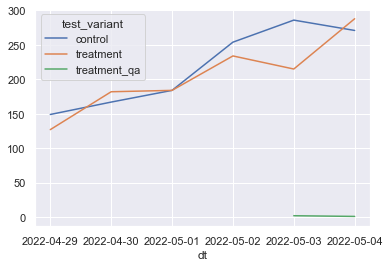

In [11]:
df.pivot_table(index='dt', columns='test_variant', values='visitor_id', aggfunc='nunique').plot()

## Remove outliers

In [12]:
# exclude qa
df = df.loc[df['test_variant']!='treatment_qa']

In [13]:
df[['dt', 'test_variant', 'visitor_id', 'order_gmv']].sort_values(by='order_gmv', ascending=False)

,dt,test_variant,visitor_id,order_gmv
2056,2022-05-02,control,2856711b-9cf9-4610-80e4-47dbb5ddce19,10786.00
2526,2022-05-04,control,0f6c8cce-c53e-4e56-9c53-f7abb7d105d3,6271.80
1994,2022-05-02,control,d8627356-1afe-49b9-a949-304dfc6708e1,5165.68
2473,2022-04-30,control,3f3d4ec3-1b93-455a-b703-c65bfbaec5f9,4704.00
2112,2022-05-03,control,a26a4172-ef37-441c-8d5c-ec699732d522,4554.70
...,...,...,...,...
2538,2022-05-01,treatment,c2a8b2a3-f8a8-4579-bf4d-9fa7355f4657,NaN
2539,2022-05-01,control,b042b5e6-317b-46b0-aee5-53cbde36c06f,NaN
2540,2022-05-02,control,e2a405dd-8a06-4c9d-b332-ac70d3faab09,NaN
2541,2022-05-04,treatment,a2386200-db44-4159-b50e-67a52137c7cc,NaN


In [14]:
# excluding 1 large order
df = df.loc[df['order_gmv']<10000]

In [15]:
metrics = df.columns[3:]
# df.groupby(['dt', 'test_variant']).apply(lambda x: x[metrics].sum()/x['visitor_id'].nunique())
dtd_metrics = df.groupby(['dt', 'test_variant']).apply(lambda x: x[metrics].sum()/x['visitor_id'].nunique()).reset_index()
dtd_metrics

,dt,test_variant,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,2022-04-29,control,5.024096,7.024096,1.662651,1.662651,1.277108,1.096386,1.024096,1.867470,1.000000,0.349398,1.325301,3.108434,583.203373,579.408193,139.078364,135.283183,0.602410,0.722892,1.108434,0.0,0.012048,0.204819,497.592048,0.0,1.445783,84.165542
1,2022-04-29,treatment,4.224138,4.482759,1.224138,1.448276,1.603448,0.775862,1.655172,1.051724,1.086207,0.517241,1.275862,1.982759,641.461207,636.978448,141.709034,137.226276,0.758621,0.517241,1.086207,0.0,0.034483,0.155172,573.729310,0.0,14.172414,53.559483
2,2022-04-30,control,6.916667,9.571429,1.380952,2.071429,1.416667,1.285714,1.142857,1.761905,1.023810,0.500000,1.190476,1.976190,457.898333,452.990000,128.073900,123.165567,0.666667,0.523810,0.833333,0.0,0.000000,0.357143,347.021429,0.0,0.000000,110.876905
3,2022-04-30,treatment,5.488889,8.011111,1.355556,1.311111,1.577778,1.011111,1.722222,1.155556,1.077778,0.533333,1.200000,1.822222,439.432667,434.964000,107.398344,102.929678,0.633333,0.566667,0.955556,0.0,0.011111,0.233333,353.550000,0.0,2.400000,83.482667
4,2022-05-01,control,5.717391,6.663043,1.434783,1.521739,1.467391,1.380435,0.989130,3.108696,1.054348,0.489130,1.228261,1.913043,478.049130,475.331739,112.060043,109.342652,0.728261,0.500000,1.086957,0.0,0.010870,0.130435,428.317283,0.0,1.834565,47.897283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2022-05-02,treatment,4.010989,6.362637,1.450549,1.670330,1.670330,1.109890,2.000000,1.208791,1.076923,0.670330,1.241758,2.769231,477.730879,474.046264,126.034584,122.349968,0.802198,0.439560,0.989011,0.0,0.010989,0.241758,401.962308,0.0,2.692308,73.076264
8,2022-05-03,control,6.010000,6.270000,1.350000,2.020000,1.240000,1.080000,1.020000,1.670000,1.020000,0.440000,1.210000,1.910000,544.822300,540.122300,129.791172,125.091172,0.710000,0.500000,0.950000,0.0,0.030000,0.230000,444.335900,0.0,7.146100,93.340300
9,2022-05-03,treatment,4.800000,5.171429,1.257143,1.128571,1.600000,0.957143,1.914286,1.157143,1.028571,0.471429,1.257143,2.157143,613.237429,610.053143,154.440234,151.255949,0.757143,0.500000,1.114286,0.0,0.028571,0.114286,510.293000,0.0,5.414286,97.530143
10,2022-05-04,control,4.927928,5.189189,1.324324,1.531532,1.387387,1.090090,0.873874,1.927928,1.009009,0.504505,1.180180,2.342342,549.649459,542.724324,125.240835,118.315700,0.603604,0.576577,0.936937,0.0,0.000000,0.243243,410.977477,0.0,0.000000,138.671982


## Day to Day Metrics Plot

In [16]:
len(metrics)

26

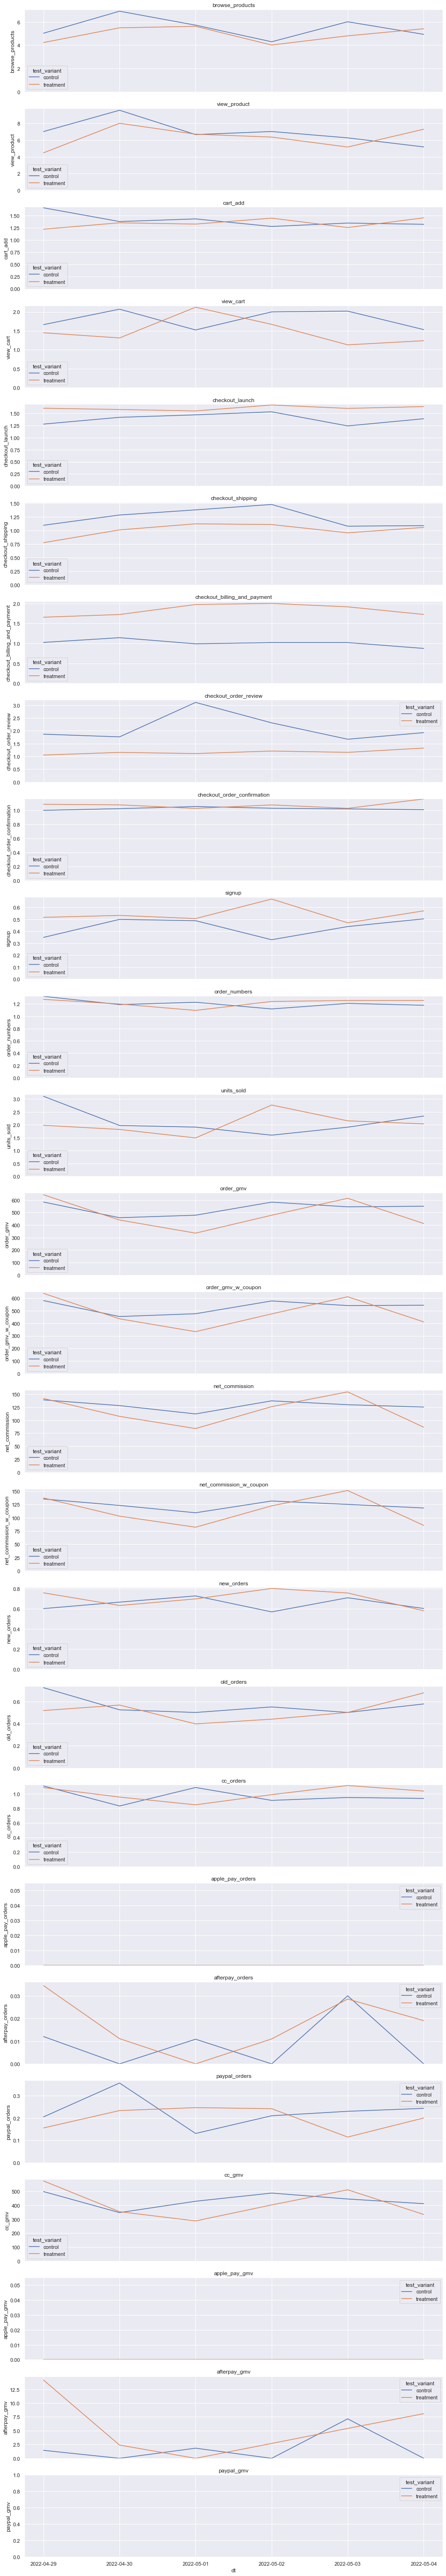

In [20]:
fig, axes = plt.subplots(26, 1, sharex=True, figsize=(16, 100))

for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i], data=dtd_metrics, x='dt', y=metric, hue='test_variant')
    axes[i].set_title(metric)
    axes[i].set_ylim(ymin=0)

## Metrics Summary

In [21]:
q = """
select 
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from wandajuan.mp_checkout_dweb_v2
where order_gmv < 10000 or order_gmv is null
group by 1, 2
"""

df_all = pd.read_sql(q, conn)

df_all

,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,treatment,69,13,98,139,25,20,18,9,7,7,6,3,10.0,23.0,3687.28,3657.28,690.6500,660.6500,2.0,8.0,3.0,0.0,0.0,7.0,2824.75,0.0,0.0,862.53
1,treatment,65,8,49,76,14,24,21,6,13,11,3,2,4.0,6.0,1517.00,1477.00,395.5700,355.5700,3.0,1.0,4.0,0.0,0.0,0.0,1517.00,0.0,0.0,0.00
2,control,5,10,158,128,23,29,16,17,10,16,7,3,9.0,17.0,5301.33,5301.33,1049.0156,1049.0156,7.0,2.0,7.0,0.0,0.0,2.0,4868.94,0.0,0.0,432.39
3,treatment,58,5,86,74,12,21,13,6,6,5,6,3,11.0,23.0,3066.90,3066.90,637.3800,637.3800,5.0,6.0,10.0,0.0,0.0,1.0,2944.90,0.0,0.0,122.00
4,treatment,49,11,102,158,20,16,17,10,16,10,7,6,10.0,13.0,1901.72,1826.72,464.7600,389.7600,8.0,2.0,10.0,0.0,0.0,0.0,1901.72,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,treatment,6,11,13,48,8,10,15,10,14,9,7,4,6.0,7.0,1152.11,1149.71,270.6800,268.2800,2.0,4.0,5.0,0.0,0.0,1.0,956.11,0.0,0.0,196.00
198,control,54,14,54,104,22,44,18,19,10,33,6,4,5.0,5.0,978.99,978.99,347.8500,347.8500,1.0,4.0,4.0,0.0,0.0,1.0,848.99,0.0,0.0,130.00
199,treatment,55,11,10,31,13,26,18,15,13,8,4,2,4.0,5.0,3263.27,3223.27,636.6200,596.6200,2.0,2.0,3.0,0.0,0.0,1.0,3081.27,0.0,0.0,182.00
200,control,24,7,23,22,6,2,8,7,5,19,3,1,5.0,8.0,3868.50,3868.50,699.4600,699.4600,3.0,2.0,5.0,0.0,0.0,0.0,3868.50,0.0,0.0,0.00


In [28]:
df_all[metrics].isna().sum().sum()
df_all[metrics] = df_all[metrics].fillna(0)

In [30]:
avg_col_list = ['avg_' + m for m in metrics]

In [31]:
df_all[avg_col_list] = df_all[metrics].div(df_all['visitors'], axis=0)
df_all

,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,avg_browse_products,avg_view_product,avg_cart_add,avg_view_cart,avg_checkout_launch,avg_checkout_shipping,avg_checkout_billing_and_payment,avg_checkout_order_review,avg_checkout_order_confirmation,avg_signup,avg_order_numbers,avg_units_sold,avg_order_gmv,avg_order_gmv_w_coupon,avg_net_commission,avg_net_commission_w_coupon,avg_new_orders,avg_old_orders,avg_cc_orders,avg_apple_pay_orders,avg_afterpay_orders,avg_paypal_orders,avg_cc_gmv,avg_apple_pay_gmv,avg_afterpay_gmv,avg_paypal_gmv
0,treatment,69,13,98,139,25,20,18,9,7,7,6,3,10.0,23.0,3687.28,3657.28,690.6500,660.6500,2.0,8.0,3.0,0.0,0.0,7.0,2824.75,0.0,0.0,862.53,7.538462,10.692308,1.923077,1.538462,1.384615,0.692308,0.538462,0.538462,0.461538,0.230769,0.769231,1.769231,283.636923,281.329231,53.126923,50.819231,0.153846,0.615385,0.230769,0.0,0.0,0.538462,217.288462,0.0,0.0,66.348462
1,treatment,65,8,49,76,14,24,21,6,13,11,3,2,4.0,6.0,1517.00,1477.00,395.5700,355.5700,3.0,1.0,4.0,0.0,0.0,0.0,1517.00,0.0,0.0,0.00,6.125000,9.500000,1.750000,3.000000,2.625000,0.750000,1.625000,1.375000,0.375000,0.250000,0.500000,0.750000,189.625000,184.625000,49.446250,44.446250,0.375000,0.125000,0.500000,0.0,0.0,0.000000,189.625000,0.0,0.0,0.000000
2,control,5,10,158,128,23,29,16,17,10,16,7,3,9.0,17.0,5301.33,5301.33,1049.0156,1049.0156,7.0,2.0,7.0,0.0,0.0,2.0,4868.94,0.0,0.0,432.39,15.800000,12.800000,2.300000,2.900000,1.600000,1.700000,1.000000,1.600000,0.700000,0.300000,0.900000,1.700000,530.133000,530.133000,104.901560,104.901560,0.700000,0.200000,0.700000,0.0,0.0,0.200000,486.894000,0.0,0.0,43.239000
3,treatment,58,5,86,74,12,21,13,6,6,5,6,3,11.0,23.0,3066.90,3066.90,637.3800,637.3800,5.0,6.0,10.0,0.0,0.0,1.0,2944.90,0.0,0.0,122.00,17.200000,14.800000,2.400000,4.200000,2.600000,1.200000,1.200000,1.000000,1.200000,0.600000,2.200000,4.600000,613.380000,613.380000,127.476000,127.476000,1.000000,1.200000,2.000000,0.0,0.0,0.200000,588.980000,0.0,0.0,24.400000
4,treatment,49,11,102,158,20,16,17,10,16,10,7,6,10.0,13.0,1901.72,1826.72,464.7600,389.7600,8.0,2.0,10.0,0.0,0.0,0.0,1901.72,0.0,0.0,0.00,9.272727,14.363636,1.818182,1.454545,1.545455,0.909091,1.454545,0.909091,0.636364,0.545455,0.909091,1.181818,172.883636,166.065455,42.250909,35.432727,0.727273,0.181818,0.909091,0.0,0.0,0.000000,172.883636,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,treatment,6,11,13,48,8,10,15,10,14,9,7,4,6.0,7.0,1152.11,1149.71,270.6800,268.2800,2.0,4.0,5.0,0.0,0.0,1.0,956.11,0.0,0.0,196.00,1.181818,4.363636,0.727273,0.909091,1.363636,0.909091,1.272727,0.818182,0.636364,0.363636,0.545455,0.636364,104.737273,104.519091,24.607273,24.389091,0.181818,0.363636,0.454545,0.0,0.0,0.090909,86.919091,0.0,0.0,17.818182
198,control,54,14,54,104,22,44,18,19,10,33,6,4,5.0,5.0,978.99,978.99,347.8500,347.8500,1.0,4.0,4.0,0.0,0.0,1.0,848.99,0.0,0.0,130.00,3.857143,7.428571,1.571429,3.142857,1.285714,1.357143,0.714286,2.357143,0.428571,0.285714,0.357143,0.357143,69.927857,69.927857,24.846429,24.846429,0.071429,0.285714,0.285714,0.0,0.0,0.071429,60.642143,0.0,0.0,9.285714
199,treatment,55,11,10,31,13,26,18,15,13,8,4,2,4.0,5.0,3263.27,3223.27,636.6200,596.6200,2.0,2.0,3.0,0.0,0.0,1.0,3081.27,0.0,0.0,182.00,0.909091,2.818182,1.181818,2.363636,1.636364,1.363636,1.181818,0.727273,0.363636,0.181818,0.363636,0.454545,296.660909,293.024545,57.874545,54.238182,0.181818,0.181818,0.272727,0.0,0.0,0.090909,280.115455,0.0,0.0,16.545455
200,cont

In [33]:
df_all.isna().sum().sum()

0

In [34]:
calculate(df_all, avg_col_list, control, treatment).reset_index()\
    .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

,Metric,Treatment Size,Treatment Total,Treatment Mean,Control Size,Control Total,Control Mean,Lift,Lift_%,P-value
0,avg_browse_products,922,4911.000000,5.3227,978,5267.000000,5.4022,-0.07954,-1.47%,0.8765
1,avg_view_product,922,7082.000000,7.7418,978,7277.000000,7.3432,0.39862,5.43%,0.4707
2,avg_cart_add,922,1364.000000,1.4964,978,1417.000000,1.4342,0.06225,4.34%,0.4181
3,avg_view_cart,922,1618.000000,1.7618,978,1764.000000,1.7375,0.02423,1.39%,0.8925
4,avg_checkout_launch,922,1538.000000,1.6703,978,1324.000000,1.3555,0.31480,23.22%,0.0000
5,avg_checkout_shipping,922,1027.000000,1.1061,978,1287.000000,1.3181,-0.21205,-16.09%,0.0003
6,avg_checkout_billing_and_payment,922,1278.000000,1.4148,978,798.000000,0.8239,0.59092,71.72%,0.0000
7,avg_checkout_order_review,922,736.000000,0.8098,978,1490.000000,1.5910,-0.78119,-49.10%,0.0000
8,avg_checkout_order_confirmation,922,541.000000,0.6048,978,599.000000,0.6212,-0.01646,-2.65%,0.5896
9,avg_signup,922,366.000000,0.4112,978,340.000000,0.3565,0.05460,15.31%,0.0992


## Slice by session level signin status

In [134]:
q = """
create table {tmp_user_table3}_by_signinstatus AS
with xo as (

select dt, test_variant, visitor_id, signin_status, session_id,

	-- xo metrics
		sum(coalesce(browse_products, 0)) browse_products,
		sum(coalesce(view_product, 0)) view_product,
 	    sum(coalesce(sm.cart_add,0)) as cart_add,
        sum(coalesce(sm.view_cart,0)) as view_cart,
	    sum(coalesce(sm.checkout_launch,0)) as checkout_launch,
    	sum(coalesce(sm.checkout_shipping,0)) as checkout_shipping,
    	sum(coalesce(sm.checkout_billing_and_payment,0)) as checkout_billing_and_payment,
    	sum(coalesce(sm.checkout_order_review,0)) as checkout_order_review,
	    sum(coalesce(sm.checkout_order_confirmation,0)) as checkout_order_confirmation,
	    sum(coalesce(sm.signup, 0)) as signup

from wandajuan.xo_metrics_mp_checkout_dweb_v2 sm
group by 1, 2, 3, 4, 5

)
, mp as (

select 

		order_date, test_variant, visitor_id,
		session_id,
	
	-- mp metrics
	    coalesce(count(distinct order_id),0) as order_numbers,
    	count(1) units_sold,
	    sum(coalesce(va.item_gmv,0)) as order_gmv,
	    sum(coalesce(va.item_gmv,0)+coalesce(placed_order_item_coupon_amount, 0)) as order_gmv_w_coupon,
	    sum(coalesce(net_commission, 0)) as net_commission,
	    sum(coalesce(net_commission, 0)+coalesce(placed_order_item_coupon_amount, 0)) as net_commission_w_coupon,
    	coalesce(count(distinct va.new_orders),0) as new_orders,
    	coalesce(count(distinct va.old_orders),0) as old_orders,    
	    coalesce(count(distinct cc_orders), 0) as cc_orders,
	    coalesce(count(distinct apple_pay_orders), 0) as apple_pay_orders,
	    coalesce(count(distinct afterpay_orders), 0) as afterpay_orders,
	    coalesce(count(distinct paypal_orders), 0) as paypal_orders,
	    sum(coalesce(cc_gmv, 0)) as cc_gmv,
	    sum(coalesce(apple_pay_gmv, 0)) as apple_pay_gmv,
	    sum(coalesce(afterpay_gmv, 0)) as afterpay_gmv,
	    sum(coalesce(paypal_gmv, 0)) as paypal_gmv
 from wandajuan.mp_metrics_mp_checkout_dweb_v2 va
 group by 1, 2, 3, 4
)
, xo_sign as (

select dt, visitor_id, session_id, cast(bool_or(cast(isusersignedin as boolean)) as int) + cast(bool_and(cast(isusersignedin as boolean)) as int) as signinstatus_xo
from wandajuan.xo_funnel_action_mp_checkout_dweb_v2
group by 1, 2, 3

)

select 
		coalesce(order_date, xo.dt) dt,
		coalesce(xo.test_variant, mp.test_variant) test_variant,
		coalesce(mp.visitor_id, xo.visitor_id) visitor_id,
		coalesce(mp.session_id, xo.session_id) session_id,
		signin_status,
		signinstatus_xo,
		
		
		browse_products,
		view_product,
		cart_add,
		view_cart,
		checkout_launch,
		checkout_shipping,
		checkout_billing_and_payment,
		checkout_order_review,
		checkout_order_confirmation,
		signup,
		
		order_numbers,
		units_sold,
		order_gmv,
		order_gmv_w_coupon,
		net_commission,
		net_commission_w_coupon,
		new_orders,
		old_orders,    
		cc_orders,
		apple_pay_orders,
		afterpay_orders,
		paypal_orders,
		cc_gmv,
		apple_pay_gmv,
		afterpay_gmv,
		paypal_gmv
from xo
full join mp
--on xo.visitor_id = mp.visitor_id and xo.dt = mp.order_date
on xo.session_id = mp.session_id
left join xo_sign
on coalesce(mp.session_id, xo.session_id) = xo_sign.session_id

""".format(tmp_user_table3= tmp_user_table3)

pd.read_sql(q, conn)

,rows
0,4344


In [200]:
# df_sign

In [ ]:
# two fields not completely corelated
df_sign[['signin_status', 'signinstatus_xo']].drop_duplicates()

Error: Session cannot generate requests

In [54]:
# prepare data by slicing `signin_status`
q = """
select 
        signin_status, 
		--signinstatus_xo,
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from wandajuan.mp_checkout_dweb_v2_by_signinstatus
where order_gmv < 10000 or order_gmv is null
group by 1, 2, 3
"""

df_sign_ss = pd.read_sql(q, conn)

df_sign_ss

,signin_status,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,SIGNED_IN_MULTIPLE,treatment,96,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ALWAYS_SIGNED_IN,control,45,3,8.0,18.0,3.0,5.0,3.0,5.0,5.0,4.0,2.0,0.0,2.0,2.0,552.74,552.74,99.5000,99.5000,1.0,1.0,1.0,0.0,0.0,1.0,76.64,0.0,0.0,476.1
2,PARTIAL_SIGNED_IN,treatment,59,3,16.0,46.0,3.0,3.0,5.0,4.0,4.0,3.0,3.0,2.0,2.0,3.0,751.01,751.01,135.1800,135.1800,1.0,1.0,2.0,0.0,0.0,0.0,751.01,0.0,0.0,0.0
3,SIGNED_OUT,control,85,4,2.0,18.0,1.0,4.0,1.0,3.0,2.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALWAYS_SIGNED_IN,treatment,22,6,13.0,23.0,3.0,4.0,8.0,3.0,7.0,7.0,5.0,0.0,5.0,8.0,822.89,822.89,207.7900,207.7900,2.0,3.0,5.0,0.0,0.0,0.0,822.89,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,SIGNED_OUT,control,5,5,80.0,50.0,8.0,8.0,5.0,6.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
677,SIGNED_OUT,control,0,4,0.0,5.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
678,ALWAYS_SIGNED_IN,treatment,78,2,14.0,4.0,3.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,3.0,3.0,1378.40,1378.40,378.2900,378.2900,0.0,3.0,3.0,0.0,0.0,0.0,1378.40,0.0,0.0,0.0
679,PARTIAL_SIGNED_IN,control,38,4,0.0,6.0,3.0,3.0,2.0,2.0,2.0,4.0,3.0,2.0,3.0,82.0,1116.00,1116.00,220.5296,220.5296,2.0,1.0,3.0,0.0,0.0,0.0,1116.00,0.0,0.0,0.0


In [41]:
df_sign_ss[metrics].isna().sum()
df_sign_ss[metrics] = df_sign_ss[metrics].fillna(0)

In [55]:
def metricSummary(df):
    df[metrics] = df[metrics].fillna(0)
    df[avg_col_list] = df[metrics].div(df['visitors'], axis=0)
    # metricSum = calculate(df, avg_col_list, control, treatment).reset_index()\
    # .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)
    # return metricSum
    return calculate(df, avg_col_list, control, treatment)#.reset_index()#\
    #.drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)


In [61]:
df_sign_ss.groupby('signin_status').apply(metricSummary).to_clipboard()
pd.set_option('display.max_rows', 10)
df_sign_ss.groupby('signin_status').apply(metricSummary).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

## Slice by signin status upon checkout

In [62]:
# prepare data by slicing `signin_status`
q = """
select 
        --signin_status, 
		signinstatus_xo,
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv
from wandajuan.mp_checkout_dweb_v2_by_signinstatus
where order_gmv < 10000 or order_gmv is null
group by 1, 2, 3
"""

df_sign_xo = pd.read_sql(q, conn)

df_sign_xo

,signinstatus_xo,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,NaN,control,74,6,40,33,6,3,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,control,74,7,20,51,7,5,9,10,4,4,3,2,3.0,4.0,1006.64,1006.64,215.8800,215.8800,1.0,2.0,2.0,0.0,0.0,1.0,923.64,0.0,0.0,83.00
2,2.0,control,48,3,0,5,2,6,5,3,0,4,1,0,2.0,3.0,338.38,313.38,70.3600,45.3600,0.0,2.0,0.0,0.0,0.0,2.0,0.00,0.0,0.0,338.38
3,2.0,control,66,1,5,3,1,0,1,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,control,63,1,0,1,1,1,3,2,1,1,1,0,1.0,4.0,2482.32,2482.32,446.8000,446.8000,1.0,0.0,1.0,0.0,0.0,0.0,2482.32,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,treatment,8,7,40,12,1,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,0.0,treatment,8,7,32,34,9,8,12,10,15,5,5,8,5.0,55.0,1531.39,1531.39,309.9975,309.9975,5.0,0.0,4.0,0.0,0.0,1.0,1316.40,0.0,0.0,214.99
669,2.0,treatment,48,2,38,41,6,42,4,2,5,4,1,1,1.0,2.0,128.98,128.98,23.2200,23.2200,0.0,1.0,1.0,0.0,0.0,0.0,128.98,0.0,0.0,0.00
670,2.0,treatment,83,3,13,7,4,8,10,5,7,4,5,0,5.0,6.0,442.16,442.16,140.1568,140.1568,1.0,4.0,5.0,0.0,0.0,0.0,442.16,0.0,0.0,0.00


In [63]:
df_sign_xo['signinstatus_xo'].replace({0.0:'Never signin', 1.0:'Signin during XO', 2.0:'Always signin'}, inplace=True)
df_sign_xo['signinstatus_xo'].fillna('Did not checkout', inplace=True)

In [65]:
df_sign_xo[metrics].isna().sum().sum()

3984

In [183]:
df_sign_xo

,signinstatus_xo,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,Always signin,control,14,2,4,4,2,2,3,1,1,5,2,0,2.0,3.0,2496.00,2471.00,507.360,482.360,1.0,1.0,2.0,0.0,0.0,0.0,2496.00,0.0,0.0,0.0
1,Always signin,control,34,3,0,13,4,6,2,1,1,3,3,0,1.0,1.0,2178.84,2178.84,392.190,392.190,0.0,1.0,1.0,0.0,0.0,0.0,2178.84,0.0,0.0,0.0
2,Always signin,control,1,1,5,14,3,2,3,3,1,1,1,0,1.0,2.0,3000.00,3000.00,540.000,540.000,1.0,0.0,1.0,0.0,0.0,0.0,3000.00,0.0,0.0,0.0
3,Did not checkout,treatment,39,4,11,33,5,6,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Never signin,treatment,39,5,12,12,5,2,6,5,7,1,1,4,1.0,1.0,157.99,157.99,28.440,28.440,1.0,0.0,1.0,0.0,0.0,0.0,157.99,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,Signin during XO,control,77,1,0,0,1,2,3,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,Never signin,control,50,3,30,26,3,1,3,3,2,2,2,2,2.0,5.0,2610.00,2610.00,469.800,469.800,2.0,0.0,2.0,0.0,0.0,0.0,2610.00,0.0,0.0,0.0
669,Did not checkout,control,50,5,24,15,1,6,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
670,Never signin,control,23,6,5,15,5,0,5,7,5,7,2,2,2.0,2.0,2554.99,2554.99,733.775,733.775,2.0,0.0,2.0,0.0,0.0,0.0,2554.99,0.0,0.0,0.0


In [66]:
df_sign_xo.groupby('signinstatus_xo').apply(metricSummary).to_clipboard()
pd.set_option('display.max_rows', None)
df_sign_xo.groupby('signinstatus_xo').apply(metricSummary).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)